In [1]:
%env KERAS_BACKEND=tensorflow

# 呼叫函數

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

In [3]:
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate, Dense
from keras.optimizers import SGD, Adam
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils
from keras import backend as K

Using TensorFlow backend.


# 載入資料

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
x_train = x_train.reshape(60000, -1)
x_test = x_test.reshape(10000, -1)


In [6]:
x_train -= x_train.min()
x_train = x_train/x_train.max()

# 建立VAE模組


In [7]:
enc_1 = Dense(100, activation='selu')
enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='selu')
dec_1 = Dense(784, activation='sigmoid')


In [9]:
x = Input(shape=(784,))
enc_x = enc_1(x)
z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

# 定義抽樣函數

In [10]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [11]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)

In [12]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          78500       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (

# 定義loss function

In [15]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

In [16]:
VAE.compile(loss=vae_loss, optimizer=Adam())
VAE.fit(x_train, x_train, batch_size=20, epochs=20)

Epoch 1/20
60000/60000 [==============================] - 23s 385us/step - loss: 187.5130
Epoch 2/20
60000/60000 [==============================] - 13s 216us/step - loss: 172.0053
Epoch 3/20
60000/60000 [==============================] - 13s 223us/step - loss: 168.7384
Epoch 4/20
60000/60000 [==============================] - 14s 225us/step - loss: 167.0829
Epoch 5/20
60000/60000 [==============================] - 14s 225us/step - loss: 165.7421
Epoch 6/20
60000/60000 [==============================] - 13s 224us/step - loss: 164.4281
Epoch 7/20
60000/60000 [==============================] - 13s 223us/step - loss: 163.1090
Epoch 8/20
60000/60000 [==============================] - 13s 223us/step - loss: 161.9780
Epoch 9/20
60000/60000 [==============================] - 13s 223us/step - loss: 160.9411
Epoch 10/20
60000/60000 [==============================] - 13s 224us/step - loss: 160.0870
Epoch 11/20
60000/60000 [==============================] - 13s 224us/step - loss: 159.4018
Epoch 12

In [17]:
VAE_Encoder = Model(x, z_mean)
VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


# 把資料視覺化

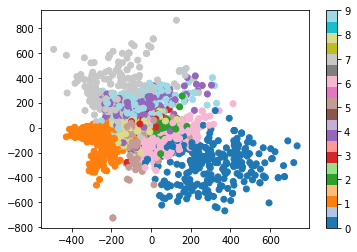

In [19]:
indices = np.random.randint(len(x_test), size=3000)
VAE_latents = VAE_Encoder.predict(x_test[indices])
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test[indices], cmap='tab20')
plt.colorbar()
plt.show()

In [20]:
h_input = Input(shape=(2,))
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))
VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_5 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


# 視覺化decoder

In [21]:
def normalized(x):
    x = x-x.min()
    x = x/x.max()
    return x

In [22]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

In [23]:
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size*n, digit_size*n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1)*digit_size:(n-i)*digit_size, j*digit_size:(j+1)*digit_size] = normalized(digit)

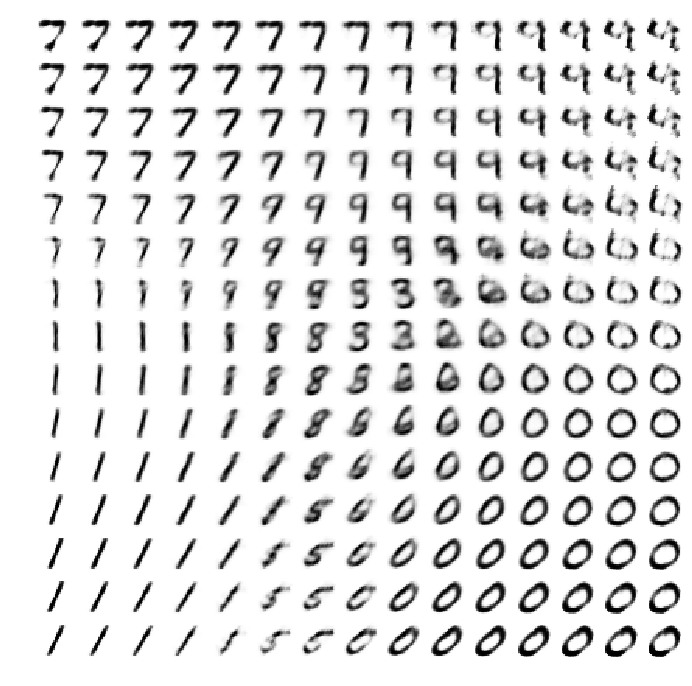

In [24]:
plt.figure(figsize=(12, 12))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()